In [171]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np

In [172]:
random_seed = 42
k = 5

### Pré-Processamento dos Dados

In [173]:
breast_cancer = datasets.load_breast_cancer()
x = breast_cancer.data
y = breast_cancer.target

df = pd.DataFrame(data=x, columns=breast_cancer.feature_names)
df['target'] = y

x = df.drop(columns=['target'])

df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [174]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


### Seleção de Features

In [175]:
maligno = df[df['target'] == 1]
benigno = df[df['target'] == 0]

p_values = []

for feature in x:
    t_stat, p_value = ttest_ind(maligno[feature], benigno[feature])
    p_values.append({'feature': feature, 'p-value': p_value})

p_values = pd.DataFrame(p_values)

features_relevantes = p_values[p_values['p-value'] < 0.05]['feature'].tolist()

In [176]:
print("Features mais relevantes:")
for i in range(len(features_relevantes)): 
    print(features_relevantes[i])

print("\nNúmero de features relevantes:", len(features_relevantes))

Features mais relevantes:
mean radius
mean texture
mean perimeter
mean area
mean smoothness
mean compactness
mean concavity
mean concave points
mean symmetry
radius error
perimeter error
area error
compactness error
concavity error
concave points error
worst radius
worst texture
worst perimeter
worst area
worst smoothness
worst compactness
worst concavity
worst concave points
worst symmetry
worst fractal dimension

Número de features relevantes: 25


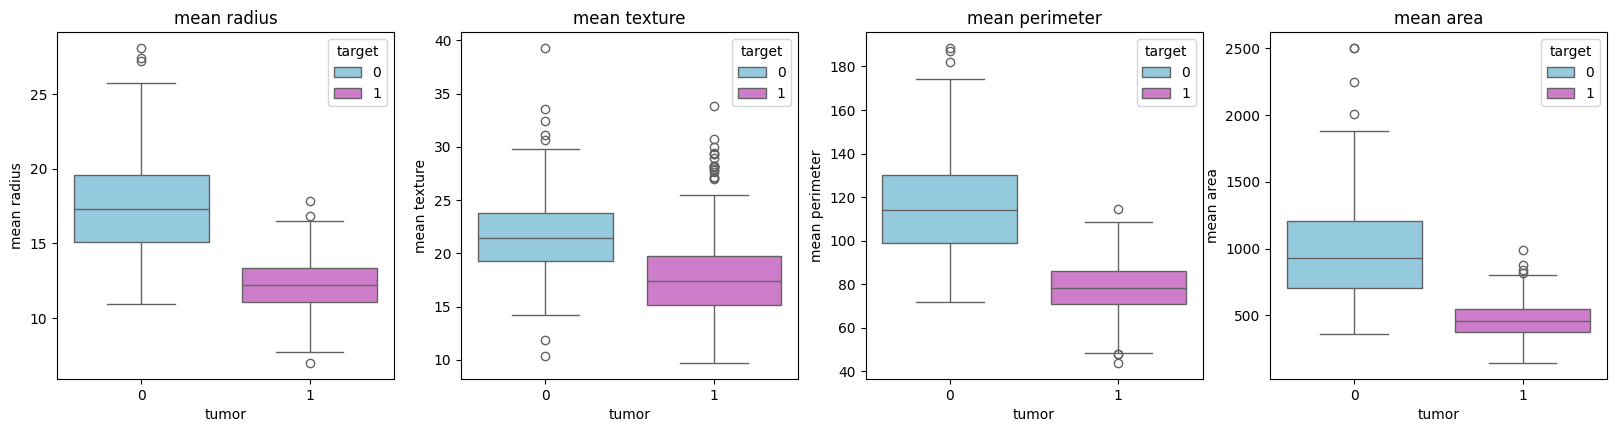

In [177]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4.5))
for i, ax in enumerate(axs):
    feature_name = features_relevantes[i]
    sns.boxplot(x='target', y=feature_name, data=df, ax=ax, hue='target', palette=['skyblue', 'orchid'])
    ax.set_ylabel(feature_name)
    ax.set_xlabel('tumor')
    ax.set_title(feature_name)

In [178]:
x = x[features_relevantes].values

### Classificador K-NN

In [179]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_scaled = scaler.transform(x)
x_test_scaled = scaler.transform(x_test)

In [180]:
k_test = 1
melhor_k = 0
melhor_acuracia = 0

while k_test <= 30:
    knn = KNeighborsClassifier(n_neighbors=k_test)
    knn.fit(x_train_scaled, y_train)

    predictions = knn.predict(x_test_scaled)

    acuracia = accuracy_score(y_test, predictions)

    if acuracia > melhor_acuracia:
        melhor_acuracia = acuracia
        melhor_k = k_test
    k_test += 1

print("Melhor k:", melhor_k)
print("Melhor acuracia:", melhor_acuracia * 100)

Melhor k: 3
Melhor acuracia: 96.49122807017544


In [181]:
knn = KNeighborsClassifier(n_neighbors=melhor_k)
knn.fit(x_train_scaled, y_train)

predictions = knn.predict(x_test_scaled)

acuracia = accuracy_score(y_test, predictions)
print("Acuracia:", acuracia * 100)

Acuracia: 96.49122807017544


### Matriz de Confusão

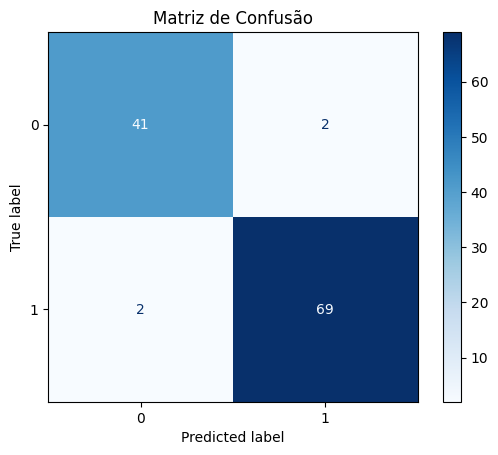

In [182]:
cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  
plt.title('Matriz de Confusão')
plt.show()

### Com ruído

In [183]:
noise_factor = 0.1

noise = np.random.normal(loc=0.0, scale=noise_factor, size=x_train_scaled.shape)

x_train_scaled_noisy = x_train_scaled + noise
x_train_scaled_aug = np.concatenate([x_train_scaled, x_train_scaled_noisy], axis=0)
y_train_aug = np.concatenate([y_train, y_train], axis=0)

knn.fit(x_train_scaled_aug, y_train_aug)

predictions_noise = knn.predict(x_test_scaled)
acuracia_noise = accuracy_score(y_test, predictions_noise)
print("Acuracia com ruido", acuracia_noise * 100)

Acuracia com ruido 94.73684210526315


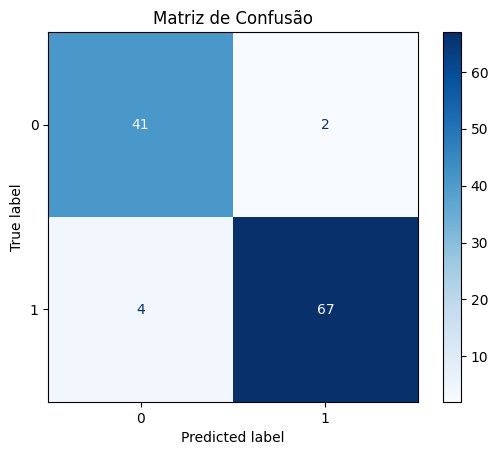

In [184]:
cm = confusion_matrix(y_test, predictions_noise)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  
plt.title('Matriz de Confusão')
plt.show()